# Pycopter
https://github.com/noether/pycopter


### Animation

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pl


def draw3d(ax, xyz, R, quadcolor):
    # We draw in ENU coordinates, R and xyz are in NED
    ax.scatter(xyz[1], xyz[0], -xyz[2], color=quadcolor)
    ax.quiver(xyz[1], xyz[0], -xyz[2], R[0, 1], R[0, 0], R[0, 2], pivot='tail', \
            color='red')
    ax.quiver(xyz[1], xyz[0], -xyz[2], R[1, 1], R[1, 0], R[1, 2], pivot='tail', \
            color='green')
    ax.quiver(xyz[1], xyz[0], -xyz[2], -R[2, 1], -R[2, 0], -R[2, 2], pivot='tail', \
            color='blue')

def draw2d(fig, X, fc, quadcolor):
    agents = fc.agents
    m = fc.m
    pl.figure(fig)

    for i in range(0, agents):
        if m == 2:
                pl.plot(X[m*i], X[m*i+1], 'o'+quadcolor[i])

def draw_edges(fig, X, fc, n):
    agents = fc.agents
    edges =  fc.edges
    m = fc.m
    B = fc.B
    pl.figure(fig)
    a, b = 0, 0

    for i in range(0, edges):
        for j in range(0, agents):
            if B[j,i] == 1:
                a = j
            elif B[j,i] == -1:
                b = j

        if m == 2:
            if i == n:
                pl.plot([X[m*a], X[m*b]], [X[m*a+1], X[m*b+1]], 'r--', lw=2)
            else:
                pl.plot([X[m*a], X[m*b]], [X[m*a+1], X[m*b+1]], 'k--', lw=2)


### Quadrotor

In [0]:
import numpy as np
from scipy import linalg as la

class quadrotor:
    def __init__(self, tag, m, l, J, CDl, CDr, kt, km, kw, att, \
            pqr, xyz, v_ned, w):
        # physical constants
        self.tag = tag
        self.m = m   # [Kg]
        self.l = l   # [m]
        self.J = J   # Inertia matrix  [Kg/m^2]
        self.Jinv = la.inv(J)
        self.CDl = CDl  # Linear Drag coefficient
        self.CDr = CDr  # Angular Drag coefficient
        self.kt = kt    # Propeller thrust [N s^2]
        self.km = km    # Propeller moment [N m s^2]
        self.kw = kw    # Motor transient [1/s]

        # Configuration of the propellers
        self.w_to_Tlmn = np.array([[   -kt,  -kt,  -kt,   -kt],\
                                   [     0,-l*kt,    0,  l*kt],\
                                   [  l*kt,    0,-l*kt,     0],\
                                   [   -km,   km,  -km,   km]])
        self.Tlmn_to_w = la.inv(self.w_to_Tlmn)
        
        # Physical variables
        self.att = att # Attitude [rad]
        self.pqr = pqr # Body angular velocity [rad/sec]
        self.xyz = xyz # Body position NED [m]
        self.v_ned = v_ned # Body linear velocity NED [m/sec]
        self.w = w # Actual angular velocity of the propellers [rad/sec]
        self.Ft = np.array([0.0, 0.0, 0.0]) # Motor (Thrust) Force [N]
        self.Fa = np.array([0.0, 0.0, 0.0]) # Aerodynamic Forces [N]
        self.Mt = np.array([0.0, 0.0, 0.0]) # Motor Moment [N m]
        self.Ma = np.array([0.0, 0.0, 0.0]) # Aerodynamic Moments [N m]
        self.crashed = 0 # Ground hit?

        ## GNC variables
        # Geometric (1) or std (0) attitude controller
        self.att_con = 1

        # Gains for the attitude controller
        self.kp = 2
        self.kq = 2
        self.kr = 2
        # Gains for classical controllers
        self.k_pos = 2e-1
        self.k_vel = 2e-1
        # Gains for Lyapunov controllers
        self.k_alt = 1e-2
        self.k_vz = 1
        self.k_xy = 1e-2
        self.k_vxy = 1e-1
        self.k_xi_g_v = 1e-1
        self.k_xi_g_e_alt = 5e-3
        self.k_xi_CD_e_v = 1e-3
        self.e_alt = 0 # We need it for the estimator xi_g
        self.e_v = np.array([0, 0]) # We need it for the estimator xi_Cd
        # Gains for geometric att controller
        self.k_eR = 5e-3
        self.k_om = 1e-2

        self.T_d = 0 # Desired thrust [N]
        self.lmn_d = np.array([0.0, 0.0, 0.0]) # Desired angular momentum [N m]
        self.w_d = w # Desired angular velocity for the propellers [rad/sec]
        # Desired attitude roll, pitch [rads]
        self.att_d = np.array([0.0, 0.0, 0.0])
        # Hoovering desired 3D position NED [m]
        self.xyz_d = np.array([0.0, 0.0, 0.0])
        self.v_ned_d = np.array([0.0, 0.0, 0.0]) # Desired vel 3D NED
        self.yaw_d = 0  # Desired yaw [rad]
        # Estimators
        self.xi_g = 9.8 # Initial guess of gravity
        self.xi_CD = 0

    ### GNC Functions ###
    def control_att(self):
        # Attitude controller Lyapunov approach
        ephi = self.att[0] - self.att_d[0]
        ethe = self.att[1] - self.att_d[1]
        epsi = self.att[2] - self.att_d[2]

        # Desired moments
        self.lmn_d[0] = -self.J[0, 0]*(ephi + self.kp*self.pqr[0]) \
             -(self.J[1, 1]-self.J[2, 2])*self.pqr[1]*self.pqr[2]

        self.lmn_d[1] = -self.J[1, 1]*(ethe + self.kq*self.pqr[1]) \
             -(self.J[2, 2]-self.J[0, 0])*self.pqr[2]*self.pqr[0] \

        self.lmn_d[2] = -self.J[2, 2]*(epsi + self.kr*self.pqr[2])

    def control_att_geometric(self):
        R = self.Rot_bn().transpose()
        Rd = self.Rotd_bn(self.att_d[0], self.att_d[1], self.att_d[2]).transpose()

        e_RM = 0.5*(Rd.transpose().dot(R) - R.transpose().dot(Rd))
        e_R = self.build_vector_from_tensor(e_RM)

        om = np.array([self.pqr[0], self.pqr[1], self.pqr[2]])
        e_om = om

        M = -self.k_eR*e_R -self.k_om*e_om + np.cross(om, self.J.dot(om))

        self.lmn_d = M


    ## Lyapunov based on controllers
    def set_xyz_ned_lya(self, xyz_d):
        e_alt  = self.xyz[2] - xyz_d[2]
        self.e_alt = e_alt
        e_xy   = self.xyz[0:2] - xyz_d[0:2]
        
        self.T_d = (-self.xi_g -self.k_alt*e_alt \
                -self.k_vz*self.v_ned[2])*self.m

        axy = -self.k_xy*e_xy -self.k_vxy*self.v_ned[0:2]
        ax = axy[0]
        ay = axy[1]
        # Guidance attitude
        phi_d = -self.m/self.T_d*(ay*np.cos(self.att[2])-ax*np.sin(self.att[2]))
        the_d =  self.m/self.T_d*(ax*np.cos(self.att[2])+ay*np.sin(self.att[2]))

        # Control motors
        self.att_d = np.array([phi_d, the_d, self.yaw_d])
        if self.att_con == 0:
            self.control_att()
        elif self.att_con == 1:
            self.control_att_geometric()

        self.w_d = np.sqrt(self.Tlmn_to_w.dot(np.append(self.T_d, self.lmn_d)))

    def set_a_2D_alt_lya(self, a_2d_d, altitude_d):
        e_alt  = self.xyz[2] - altitude_d
        self.e_alt = e_alt
        self.T_d = (-self.xi_g -self.k_alt*e_alt \
                -self.k_vz*self.v_ned[2])*self.m

        ax = a_2d_d[0]
        ay = a_2d_d[1]
        # Guidance attitude
        phi_d = -self.m/self.T_d*(ay*np.cos(self.att[2])-ax*np.sin(self.att[2]))
        the_d =  self.m/self.T_d*(ax*np.cos(self.att[2])+ay*np.sin(self.att[2]))

        # Control motors
        self.att_d = np.array([phi_d, the_d, self.yaw_d])
        if self.att_con == 0:
            self.control_att()
        elif self.att_con == 1:
            self.control_att_geometric()

        self.w_d = np.sqrt(self.Tlmn_to_w.dot(np.append(self.T_d, self.lmn_d)))

    def step_estimator_xi_g(self, dt):
        self.xi_g = self.xi_g + self.k_xi_g_v*self.v_ned[2]*dt \
        + self.k_xi_g_e_alt*self.e_alt*dt

    def set_v_2D_alt_lya(self, vxy_d, alt_d):
        e_alt  = self.xyz[2] - alt_d
        self.e_alt = e_alt
        vxy = self.v_ned[0:2]
        e_v = vxy - vxy_d
        self.e_v = e_v

        self.T_d = (-self.xi_g -self.k_alt*e_alt \
                -self.k_vz*self.v_ned[2])*self.m


        axy = self.xi_CD*la.norm(vxy)*vxy -self.k_vxy*e_v
        ax = axy[0]
        ay = axy[1]
        # Guidance attitude
        phi_d = -self.m/self.T_d*(ay*np.cos(self.att[2])-ax*np.sin(self.att[2]))
        the_d =  self.m/self.T_d*(ax*np.cos(self.att[2])+ay*np.sin(self.att[2]))

        # Control motors
        self.att_d = np.array([phi_d, the_d, self.yaw_d])
        if self.att_con == 0:
            self.control_att()
        elif self.att_con == 1:
            self.control_att_geometric()

        self.w_d = np.sqrt(self.Tlmn_to_w.dot(np.append(self.T_d, self.lmn_d)))

    def step_estimator_xi_CD(self, dt):
        self.xi_CD = self.xi_CD \
                - self.k_xi_CD_e_v*la.norm(self.v_ned[0:2])*(self.e_v.T).dot(self.v_ned[0:2])*dt

    ### Physics Simulation ###
    def step(self, dt):
        self.step_rotors(dt)
        self.step_6DoF(dt)
        self.step_estimator_xi_g(dt)
        self.step_estimator_xi_CD(dt)

    def step_rotors(self, dt): # Motors modelled as 1st order linear system
        # Check Saturation 
        for i in range (0, 4):
            if self.w_d[i] < 0:
                self.w_d[i] = 0
            elif self.w_d[i] > 500:
                self.w_d[i] = 500

        e_w = self.w - self.w_d
        w_dot = -self.kw*np.identity(4).dot(e_w)
        self.w = self.w + w_dot*dt

    def step_6DoF(self, dt):
        Rbn = self.Rot_bn() # Rotational matrix from Nav to Body
        g = np.array([0, 0, 9.81]) # Gravity vector
        p_dot = Rbn.dot(self.v_ned) # Velocity in body coordinates

        self.rotors_forces_moments() # Forces and moments by motors
        self.aero_forces_moments()   # Forces and moments by environment

        # Time derivatives (acc and vel) given by physics equations
        att_dot = (self.R_pqr()).dot(self.pqr)
        p_ddot = (self.Ft + self.Fa)/self.m + Rbn.dot(g) \
                - np.cross(self.pqr, p_dot)
        pqr_dot = self.Jinv.dot(self.Mt + self.Ma \
                - np.cross(self.pqr, self.J.dot(self.pqr)))

        # Propagation of positions/angles and velocities
        self.att = self.att + att_dot*dt
        #for i in range(0,3):
        #    self.att[i] = self.norm_ang(self.att[i])
        self.pqr = self.pqr + pqr_dot*dt

        # Touching the ground?
        if self.xyz[2] > 0:
            self.xyz[2] = 0
            if la.norm(self.v_ned) > 0.5:
                print self.tag, "crashed into the ground"
                self.crashed = 1
            self.v_ned[0:3] = 0
        else:
            self.v_ned = self.v_ned + Rbn.T.dot(p_ddot)*dt
            self.xyz = self.xyz + self.v_ned*dt

    # Forces and moments given by motors and environment
    def rotors_forces_moments(self):
        Tlmn = self.w_to_Tlmn.dot(np.array([self.w[0]**2, \
                self.w[1]**2, self.w[2]**2, self.w[3]**2]))

        self.Ft = np.array([0, 0, Tlmn[0]]) # Thrust
        self.Mt = Tlmn[1:4] # Moment

    def aero_forces_moments(self):
        Rbn = self.Rot_bn()
        p_dot = Rbn.dot(self.v_ned)

        Dl = -p_dot*la.norm(p_dot)*self.CDl # Linear drag
        Dr = -self.pqr*la.norm(self.pqr)*self.CDr # Angular drag
        
        self.Fa = Dl # Forces by the environment
        self.Ma = Dr # Moments by the environment

    ### Misc ###
    # Angles always between -pi and pi
    def norm_ang(self, x):
        if x > np.pi:
            x = x - 2*np.pi
        elif x <= -np.pi:
            x = x + 2*np.pi
        return x
    
    # Rotational matrix from Nav to Body
    def Rot_bn(self):
        phi = self.att[0]
        theta = self.att[1]
        psi = self.att[2]
        cphi = np.cos(phi)
        sphi = np.sin(phi)
        cthe = np.cos(theta)
        sthe = np.sin(theta)
        cpsi = np.cos(psi)
        spsi = np.sin(psi)

        Rx = np.array([[1,    0,      0], \
                       [0,  cphi,  sphi], \
                       [0, -sphi,  cphi]])

        Ry = np.array([[cthe,  0,  -sthe], \
                       [   0,  1,      0], \
                       [sthe,  0,   cthe]])

        Rz = np.array([[ cpsi,  spsi, 0], \
                       [-spsi,  cpsi, 0], \
                       [    0,    0, 1]])

        R = Rx.dot(Ry).dot(Rz)
        return R

    # Rotation matrix from Nav to given Body attitude
    def Rotd_bn(self, phi, theta, psi):
        cphi = np.cos(phi)
        sphi = np.sin(phi)
        cthe = np.cos(theta)
        sthe = np.sin(theta)
        cpsi = np.cos(psi)
        spsi = np.sin(psi)

        Rx = np.array([[1,    0,      0], \
                       [0,  cphi,  sphi], \
                       [0, -sphi,  cphi]])

        Ry = np.array([[cthe,  0,  -sthe], \
                       [   0,  1,      0], \
                       [sthe,  0,   cthe]])

        Rz = np.array([[ cpsi,  spsi, 0], \
                       [-spsi,  cpsi, 0], \
                       [    0,    0, 1]])

        R = Rx.dot(Ry).dot(Rz)
        return R

    
    # Propagation matrix for computing the angular velocity of the attitude
    def R_pqr(self):
        phi = self.att[0]
        theta = self.att[1]
        tthe = np.tan(theta)
        cthe = np.cos(theta)
        cphi = np.cos(phi)
        sphi = np.sin(phi)

        R = np.array([[1, tthe*sphi, tthe*cphi], \
                      [0,      cphi,     -sphi], \
                      [0, sphi/cthe, cphi/cthe]])
        return R

    # Building a tensor from vector and viceversa
    def build_tensor_from_vector(self, a, b, c):
        T = np.array([[ 0, -c,  b],
                      [ c,  0, -a],
                      [-b,  a,  0]])
        return T

    def build_vector_from_tensor(self, T):
        v = np.array([T[2, 1], T[0, 2], T[1, 0]])
        return v


### Quad log

In [0]:
import numpy as np

class quadlog:
    def __init__(self, time):
        self.att_h = np.zeros((time.size, 3))
        self.pqr_h = np.zeros((time.size, 3))
        self.xyz_h = np.zeros((time.size, 3))
        self.v_ned_h = np.zeros((time.size, 3))
        self.w_h = np.zeros((time.size, 4))
        self.xi_g_h = np.zeros(time.size)
        self.xi_CD_h = np.zeros(time.size)


### Formation distance

In [0]:
import numpy as np
from scipy import linalg as la

class formation_distance:
    def __init__(self, m, l, d, mu, tilde_mu, B, c_shape, c_vel):
        self.m = m
        self.l = l
        self.d = d
        self.mu = mu
        self.tilde_mu = tilde_mu
        self.B = B
        self.agents, self.edges = self.B.shape
        self.S1 = self.make_S1()
        self.S2 = self.make_S2()
        self.Av = self.make_Av()
        self.Aa = self.Av.dot(self.B.T).dot(self.Av)
        self.Bb = la.kron(self.B, np.eye(self.m))
        self.S1b = la.kron(self.S1, np.eye(self.m))
        self.S2b = la.kron(self.S2, np.eye(self.m))
        self.Avb = la.kron(self.Av, np.eye(self.m))
        self.Aab = la.kron(self.Aa, np.eye(self.m))
        self.Ed = np.zeros(self.edges)
        self.Ev = np.zeros(self.edges*self.m)

        self.c_shape = c_shape
        self.c_vel = c_vel

    def u_acc(self, X, V):
        Z = self.Bb.T.dot(X)
        Dz = self.make_Dz(Z)
        Dzt = self.make_Dzt(Z)
        self.Ed = self.make_E(Z)
        U = -self.c_shape*self.Bb.dot(Dz).dot(Dzt).dot(self.Ed) + \
                self.c_vel*self.Avb.dot(Z) + self.Aab.dot(Z) \
                - self.c_vel*V
        return U

    def u_vel(self, X):
        Z = self.Bb.T.dot(X)
        Dz = self.make_Dz(Z)
        Dzt = self.make_Dzt(Z)
        self.Ed = self.make_E(Z)
        U = -self.c_shape*self.Bb.dot(Dz).dot(Dzt).dot(self.Ed) \
                + self.Avb.dot(Z)
        return U

    def make_S1(self):
        S1 = np.zeros_like(self.B)

        for i in range(0, self.agents):
            for j in range(0, self.edges):
                if self.B[i,j] == 1:
                    S1[i,j] = 1

        return S1

    def make_S2(self):
        S2 = np.zeros_like(-self.B)

        for i in range(0, self.agents):
            for j in range(0, self.edges):
                if self.B[i,j] == 1:
                    S2[i,j] = 1
        return S2

    def make_Bd(self):
        Bd = np.copy(self.B)

        for i in range(0, self.edges):
            Bd[0, i] = 0

        return Bd

    def make_Dz(self, Z):
        Dz = np.zeros((Z.size, self.edges))
    
        j = 0

        for i in range(0, self.edges):
            Dz[j:j+self.m, i] =  Z[j:j+self.m]
            j+=self.m

        return Dz

    def make_Dzt(self, Z):
        if self.l == 2:
            return np.eye(self.edges)

        Zt = np.zeros(self.edges)
        for i in range(0, self.edges):
            Zt[i] = (la.norm(Z[(i*self.m):(i*self.m+self.m)]))**(self.l-2)
        
        return np.diag(Zt)

    def make_E(self, Z):
        E = np.zeros(self.edges)
        for i in range(0, self.edges):
            E[i] = (la.norm(Z[(i*self.m):(i*self.m+self.m)]))**self.l \
                    - self.d[i]**self.l

        return E

    def make_Av(self):
        A = np.zeros(self.B.shape)
        for i in range(0, self.agents):
            for j in range(0, self.edges):
                if self.B[i,j] == 1:
                    A[i,j] = self.mu[j]
                elif self.B[i,j] == -1:
                    A[i,j] = self.tilde_mu[j]

        return A




/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


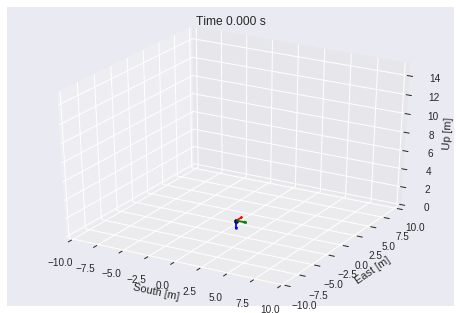

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

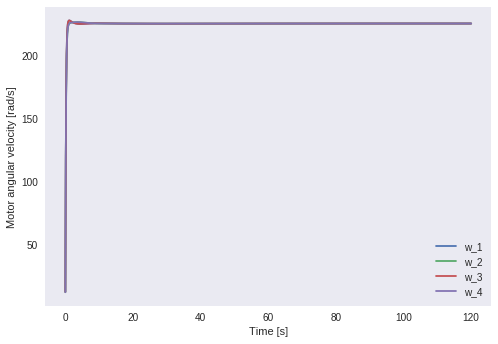

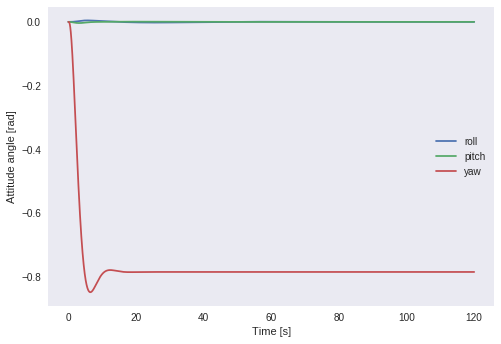

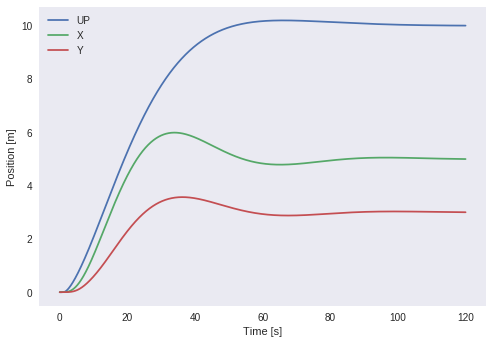

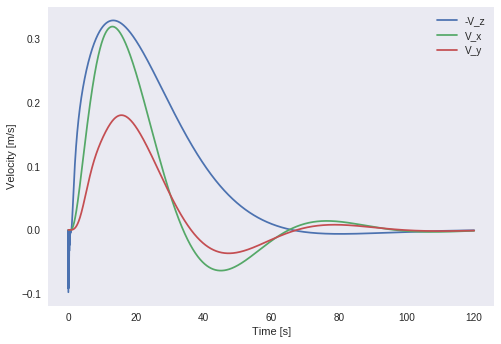

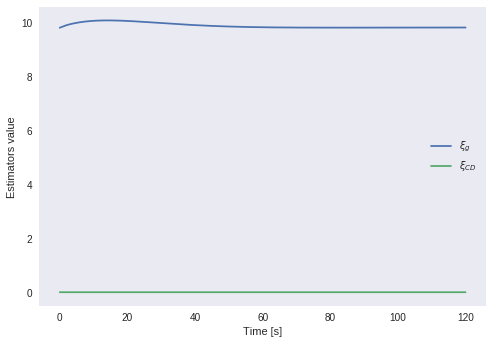

KeyboardInterrupt: ignored

In [13]:
from scipy import linalg as la
import matplotlib.pyplot as pl
import numpy as np

### MARK
#import quadrotor as quad
#import quadlog
#import animation as ani
### MARK

# Quadrotor
m = 0.65 # Kg
l = 0.23 # m
Jxx = 7.5e-3 # Kg/m^2
Jyy = Jxx
Jzz = 1.3e-2
Jxy = 0
Jxz = 0
Jyz = 0
J = np.array([[Jxx, Jxy, Jxz], \
              [Jxy, Jyy, Jyz], \
              [Jxz, Jyz, Jzz]])
CDl = 9e-3
CDr = 9e-4
kt = 3.13e-5  # Ns^2
km = 7.5e-7   # Ns^2
kw = 1/0.18   # rad/s

# Initial conditions
att_0 = np.array([0.0, 0.0, 0.0])
pqr_0 = np.array([0.0, 0.0, 0.0])
xyz_0 = np.array([0.0, 0.0, 0.0])
v_ned_0 = np.array([0.0, 0.0, 0.0])
w_0 = np.array([0.0, 0.0, 0.0, 0.0])

# Setting quads
q1 = quadrotor(1, m, l, J, CDl, CDr, kt, km, kw, \
        att_0, pqr_0, xyz_0, v_ned_0, w_0)

# Simulation parameters
tf = 120
dt = 1e-2
time = np.linspace(0, tf, tf/dt)
it = 0
frames = 100

# Data log
q1_log = quadlog(time)

# Plots
quadcolor = ['k']
pl.close("all")
pl.ion()
fig = pl.figure(0)
axis3d = fig.add_subplot(111, projection='3d')
pl.figure(0)

# Desired position and heading
xyz_d = np.array([5, 3, -10])
q1.yaw_d = -np.pi/4

for t in time:

    # Simulation
    q1.set_xyz_ned_lya(xyz_d)
    q1.step(dt)

    # Animation
    if it%frames == 0:

        axis3d.cla()
        draw3d(axis3d, q1.xyz, q1.Rot_bn(), quadcolor[0])
        axis3d.set_xlim(-10, 10)
        axis3d.set_ylim(-10, 10)
        axis3d.set_zlim(0, 15)
        axis3d.set_xlabel('South [m]')
        axis3d.set_ylabel('East [m]')
        axis3d.set_zlabel('Up [m]')
        axis3d.set_title("Time %.3f s" %t)
        pl.pause(0.001)
        pl.draw()
        

    # Log
    q1_log.xyz_h[it, :] = q1.xyz
    q1_log.att_h[it, :] = q1.att
    q1_log.w_h[it, :] = q1.w
    q1_log.v_ned_h[it, :] = q1.v_ned
    q1_log.xi_g_h[it] = q1.xi_g
    q1_log.xi_CD_h[it] = q1.xi_CD


    it+=1
    
    # Stop if crash
    if (q1.crashed == 1):
        break

pl.figure(1)
pl.plot(time, q1_log.w_h[:, 0], label="w_1")
pl.plot(time, q1_log.w_h[:, 1], label="w_2")
pl.plot(time, q1_log.w_h[:, 2], label="w_3")
pl.plot(time, q1_log.w_h[:, 3], label="w_4")
pl.xlabel("Time [s]")
pl.ylabel("Motor angular velocity [rad/s]")
pl.grid()
pl.legend()

pl.figure(2)
pl.plot(time, q1_log.att_h[:, 0], label="roll")
pl.plot(time, q1_log.att_h[:, 1], label="pitch")
pl.plot(time, q1_log.att_h[:, 2], label="yaw")
pl.xlabel("Time [s]")
pl.ylabel("Attitude angle [rad]")
pl.grid()
pl.legend()

pl.figure(3)
pl.plot(time, -q1_log.xyz_h[:, 2], label="UP")
pl.plot(time, q1_log.xyz_h[:, 0], label="X")
pl.plot(time, q1_log.xyz_h[:, 1], label="Y")
pl.xlabel("Time [s]")
pl.ylabel("Position [m]")
pl.grid()
pl.legend()

pl.figure(4)
pl.plot(time, -q1_log.v_ned_h[:, 2], label="-V_z")
pl.plot(time, q1_log.v_ned_h[:, 0], label="V_x")
pl.plot(time, q1_log.v_ned_h[:, 1], label="V_y")
pl.xlabel("Time [s]")
pl.ylabel("Velocity [m/s]")
pl.grid()
pl.legend()

pl.figure(5)
pl.plot(time, q1_log.xi_g_h, label="${\\xi}_g$")
pl.plot(time, q1_log.xi_CD_h, label="${\\xi}_{CD}$")
pl.xlabel("Time [s]")
pl.ylabel("Estimators value")
pl.grid()
pl.legend()

pl.pause(0)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


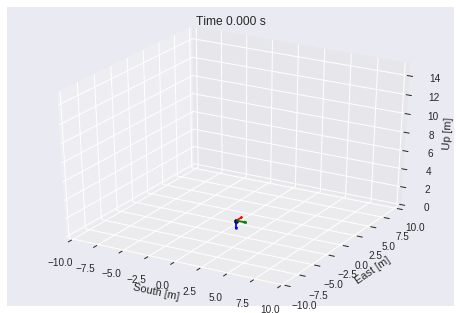

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

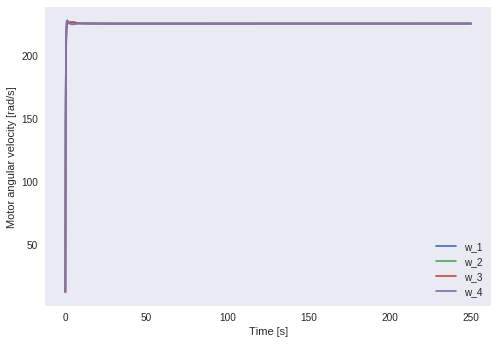

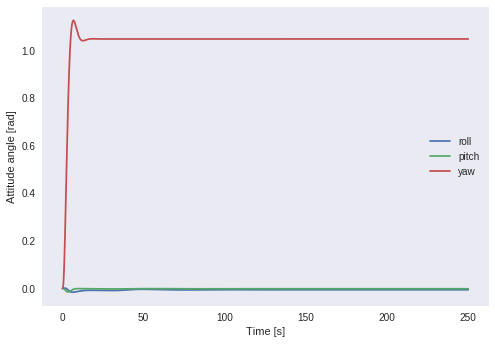

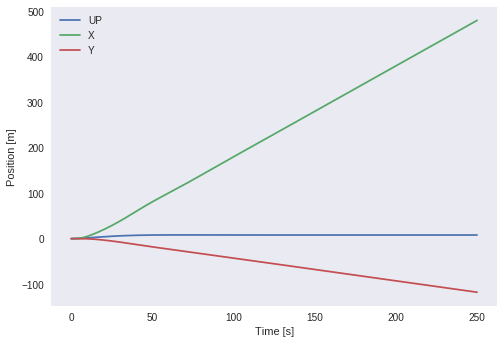

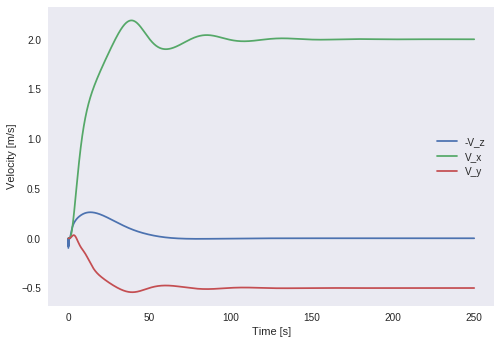

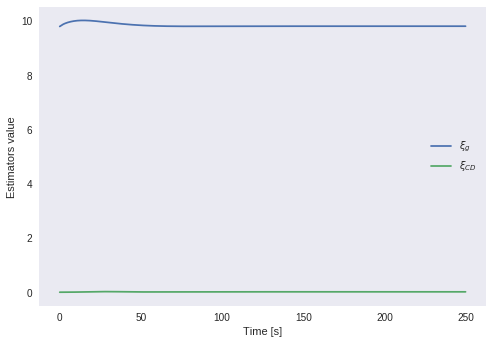

KeyboardInterrupt: ignored

In [14]:
from scipy import linalg as la
import matplotlib.pyplot as pl
import numpy as np

### MARK
#import quadrotor as quad
#import quadlog
#import animation as ani
### MARK


# Quadrotor
m = 0.65 # Kg
l = 0.23 # m
Jxx = 7.5e-3 # Kg/m^2
Jyy = Jxx
Jzz = 1.3e-2
Jxy = 0
Jxz = 0
Jyz = 0
J = np.array([[Jxx, Jxy, Jxz], \
              [Jxy, Jyy, Jyz], \
              [Jxz, Jyz, Jzz]])
CDl = 9e-3
CDr = 9e-4
kt = 3.13e-5  # Ns^2
km = 7.5e-7   # Ns^2
kw = 1/0.18   # rad/s

# Initial conditions
att_0 = np.array([0.0, 0.0, 0.0])
pqr_0 = np.array([0.0, 0.0, 0.0])
xyz_0 = np.array([0.0, 0.0, 0.0])
v_ned_0 = np.array([0.0, 0.0, 0.0])
w_0 = np.array([0.0, 0.0, 0.0, 0.0])

# Setting quads
q1 = quadrotor(1, m, l, J, CDl, CDr, kt, km, kw, \
        att_0, pqr_0, xyz_0, v_ned_0, w_0)

# Simulation parameters
tf = 250
dt = 1e-2
time = np.linspace(0, tf, tf/dt)
it = 0
frames = 100

# Data log
q1_log = quadlog(time)

# Plots
quadcolor = ['k']
pl.close("all")
pl.ion()
fig = pl.figure(0)
axis3d = fig.add_subplot(111, projection='3d')

# Desired position and heading
v_2D_d = np.array([2, -0.5])
alt_d = -8
q1.yaw_d = np.pi/3

for t in time:

    # Simulation
    q1.set_v_2D_alt_lya(v_2D_d, alt_d)
    q1.step(dt)

    # Animation
    if it%frames == 0:

        pl.figure(0)
        axis3d.cla()
        draw3d(axis3d, q1.xyz, q1.Rot_bn(), quadcolor[0])
        axis3d.set_xlim(-10, 10)
        axis3d.set_ylim(-10, 10)
        axis3d.set_zlim(0, 15)
        axis3d.set_xlabel('South [m]')
        axis3d.set_ylabel('East [m]')
        axis3d.set_zlabel('Up [m]')
        axis3d.set_title("Time %.3f s" %t)
        pl.pause(0.001)
        pl.draw()
        

    # Log
    q1_log.xyz_h[it, :] = q1.xyz
    q1_log.att_h[it, :] = q1.att
    q1_log.w_h[it, :] = q1.w
    q1_log.v_ned_h[it, :] = q1.v_ned
    q1_log.xi_g_h[it] = q1.xi_g
    q1_log.xi_CD_h[it] = q1.xi_CD

    it+=1
    
    # Stop if crash
    if (q1.crashed == 1):
        break

pl.figure(1)
pl.plot(time, q1_log.w_h[:, 0], label="w_1")
pl.plot(time, q1_log.w_h[:, 1], label="w_2")
pl.plot(time, q1_log.w_h[:, 2], label="w_3")
pl.plot(time, q1_log.w_h[:, 3], label="w_4")
pl.xlabel("Time [s]")
pl.ylabel("Motor angular velocity [rad/s]")
pl.grid()
pl.legend()

pl.figure(2)
pl.plot(time, q1_log.att_h[:, 0], label="roll")
pl.plot(time, q1_log.att_h[:, 1], label="pitch")
pl.plot(time, q1_log.att_h[:, 2], label="yaw")
pl.xlabel("Time [s]")
pl.ylabel("Attitude angle [rad]")
pl.grid()
pl.legend()

pl.figure(3)
pl.plot(time, -q1_log.xyz_h[:, 2], label="UP")
pl.plot(time, q1_log.xyz_h[:, 0], label="X")
pl.plot(time, q1_log.xyz_h[:, 1], label="Y")
pl.xlabel("Time [s]")
pl.ylabel("Position [m]")
pl.grid()
pl.legend()

pl.figure(4)
pl.plot(time, -q1_log.v_ned_h[:, 2], label="-V_z")
pl.plot(time, q1_log.v_ned_h[:, 0], label="V_x")
pl.plot(time, q1_log.v_ned_h[:, 1], label="V_y")
pl.xlabel("Time [s]")
pl.ylabel("Velocity [m/s]")
pl.grid()
pl.legend()

pl.figure(5)
pl.plot(time, q1_log.xi_g_h, label="${\\xi}_g$")
pl.plot(time, q1_log.xi_CD_h, label="${\\xi}_{CD}$")
pl.xlabel("Time [s]")
pl.ylabel("Estimators value")
pl.grid()
pl.legend()

pl.pause(0)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


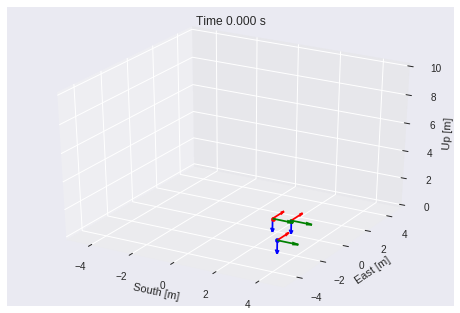

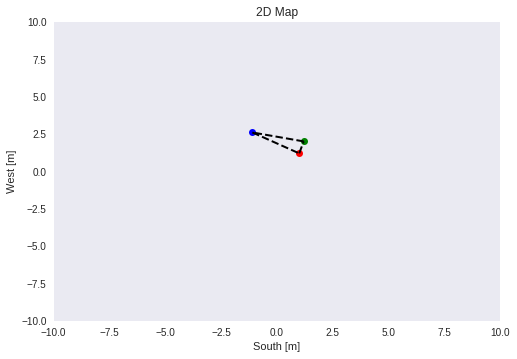

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

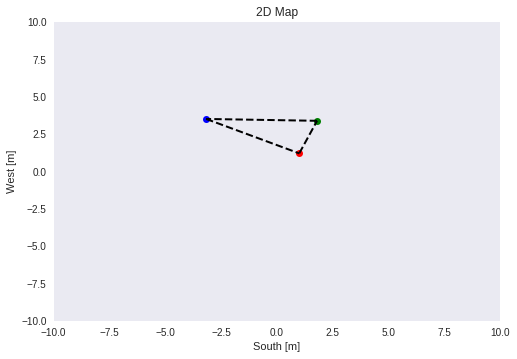

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

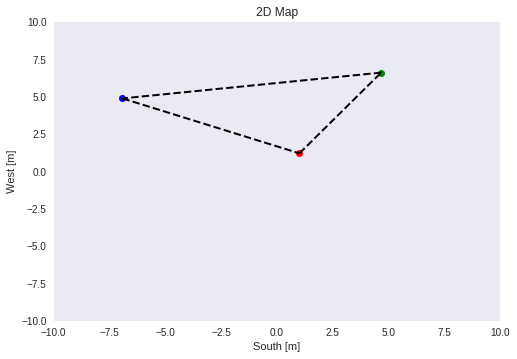

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

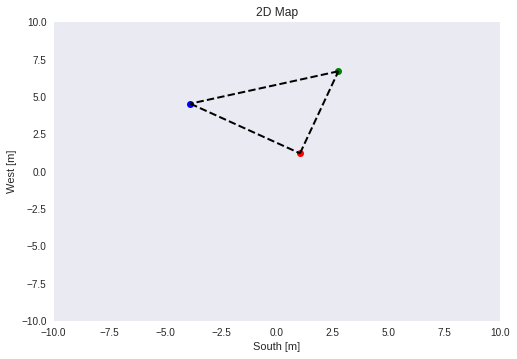

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

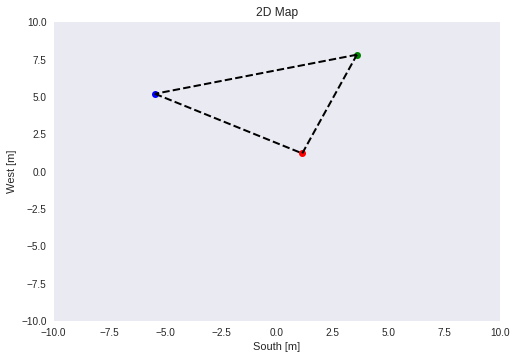

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

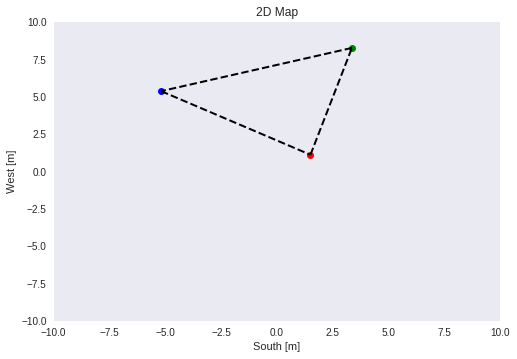

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

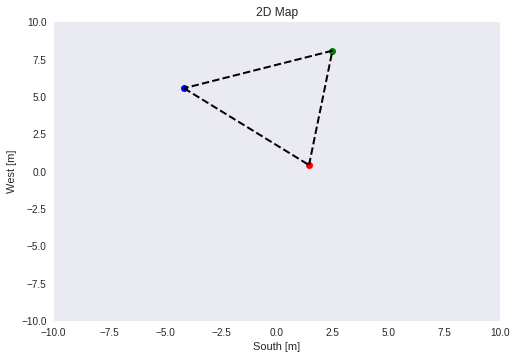

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

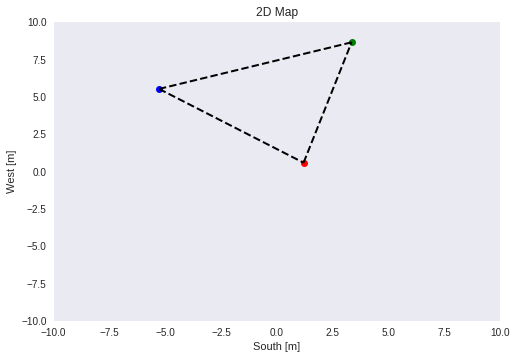

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

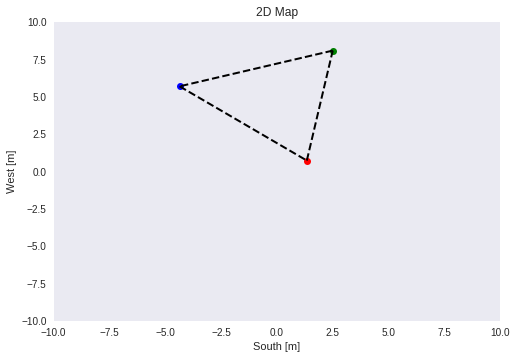

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

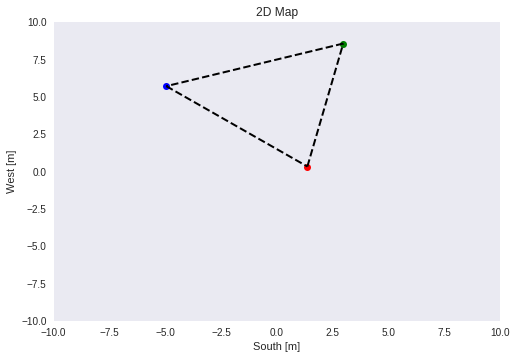

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

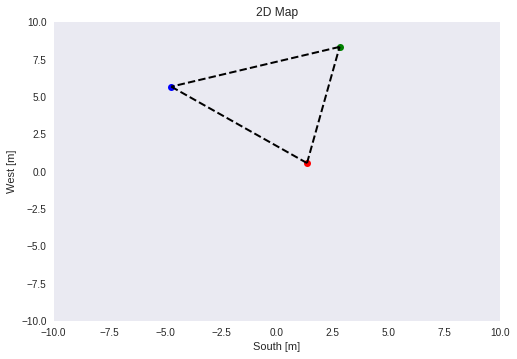

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

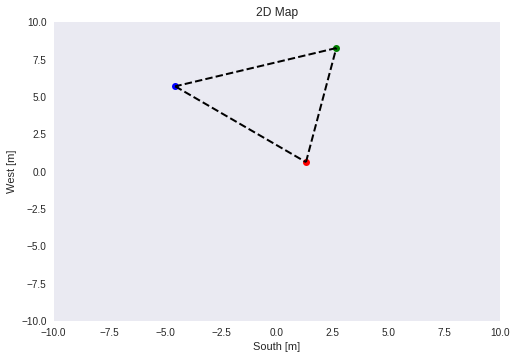

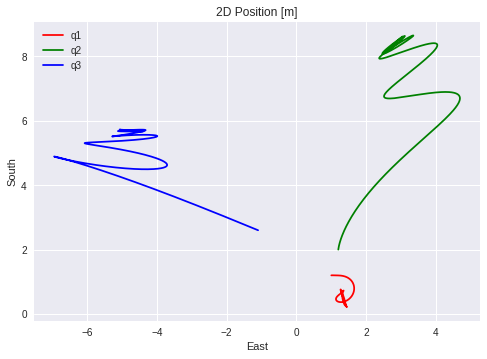

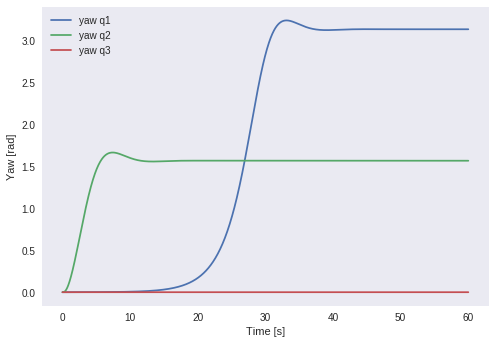

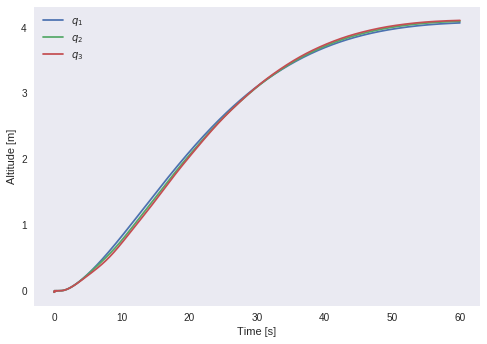

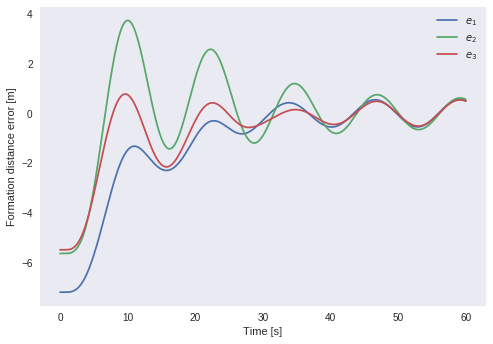

KeyboardInterrupt: ignored

In [18]:
from scipy import linalg as la
import matplotlib.pyplot as pl
import numpy as np

### MARK
#import quadrotor as quad
#import formation_distance as form
#import quadlog
#import animation as ani

### MARK 


# Quadrotor
m = 0.65 # Kg
l = 0.23 # m
Jxx = 7.5e-3 # Kg/m^2
Jyy = Jxx
Jzz = 1.3e-2
Jxy = 0
Jxz = 0
Jyz = 0
J = np.array([[Jxx, Jxy, Jxz], \
              [Jxy, Jyy, Jyz], \
              [Jxz, Jyz, Jzz]])
CDl = 9e-3
CDr = 9e-4
kt = 3.13e-5  # Ns^2
km = 7.5e-7   # Ns^2
kw = 1/0.18   # rad/s

# Initial conditions
att_0 = np.array([0.0, 0.0, 0.0])
pqr_0 = np.array([0.0, 0.0, 0.0])
xyz1_0 = np.array([1.0, 1.2, 0.0])
xyz2_0 = np.array([1.2, 2.0, 0.0])
xyz3_0 = np.array([-1.1, 2.6, 0.0])
v_ned_0 = np.array([0.0, 0.0, 0.0])
w_0 = np.array([0.0, 0.0, 0.0, 0.0])

# Setting quads
q1 = quadrotor(1, m, l, J, CDl, CDr, kt, km, kw, \
        att_0, pqr_0, xyz1_0, v_ned_0, w_0)

q2 = quadrotor(2, m, l, J, CDl, CDr, kt, km, kw, \
        att_0, pqr_0, xyz2_0, v_ned_0, w_0)

q3 = quadrotor(3, m, l, J, CDl, CDr, kt, km, kw, \
        att_0, pqr_0, xyz3_0, v_ned_0, w_0)

# Formation Control
# Shape
side = 8
Btriang = np.array([[1, 0, -1],[-1, 1, 0],[0, -1, 1]])
dtriang = np.array([side, side, side])

# Motion
mu = 0e-2*np.array([1, 1, 1])
tilde_mu = 0e-2*np.array([1, 1, 1])

fc = formation_distance(2, 1, dtriang, mu, tilde_mu, Btriang, 5e-2, 5e-1)

# Simulation parameters
tf = 60
dt = 5e-2
time = np.linspace(0, tf, tf/dt)
it = 0
frames = 100

# Data log
q1_log = quadlog(time)
q2_log = quadlog(time)
q3_log = quadlog(time)
Ed_log = np.zeros((time.size, fc.edges))

# Plots
quadcolor = ['r', 'g', 'b']
pl.close("all")
pl.ion()
fig = pl.figure(0)
axis3d = fig.add_subplot(111, projection='3d')

init_area = 5
s = 2

# Desired altitude and heading
alt_d = 4
q1.yaw_d = -np.pi
q2.yaw_d =  np.pi/2
q3.yaw_d =  0

for t in time:

    # Simulation
    X = np.append(q1.xyz[0:2], np.append(q2.xyz[0:2], q3.xyz[0:2]))
    V = np.append(q1.v_ned[0:2], np.append(q2.v_ned[0:2], q3.v_ned[0:2]))
    U = fc.u_acc(X, V)

    q1.set_a_2D_alt_lya(U[0:2], -alt_d)
    q2.set_a_2D_alt_lya(U[2:4], -alt_d)
    q3.set_a_2D_alt_lya(U[4:6], -alt_d)

    q1.step(dt)
    q2.step(dt)
    q3.step(dt)

    # Animation
    if it%frames == 0:

        pl.figure(0)
        axis3d.cla()
        draw3d(axis3d, q1.xyz, q1.Rot_bn(), quadcolor[0])
        draw3d(axis3d, q2.xyz, q2.Rot_bn(), quadcolor[1])
        draw3d(axis3d, q3.xyz, q3.Rot_bn(), quadcolor[2])
        axis3d.set_xlim(-5, 5)
        axis3d.set_ylim(-5, 5)
        axis3d.set_zlim(0, 10)
        axis3d.set_xlabel('South [m]')
        axis3d.set_ylabel('East [m]')
        axis3d.set_zlabel('Up [m]')
        axis3d.set_title("Time %.3f s" %t)
        pl.pause(0.001)
        pl.draw()
        #namepic = '%i'%it
        #digits = len(str(it))
        #for j in range(0, 5-digits):
        #    namepic = '0' + namepic
        #pl.savefig("./images/%s.png"%namepic)
        
        pl.figure(1)
        pl.clf()
        draw2d(1, X, fc, quadcolor)
        draw_edges(1, X, fc, -1)
        pl.xlabel('South [m]')
        pl.ylabel('West [m]')
        pl.title('2D Map')
        pl.xlim(-s*init_area, s*init_area)
        pl.ylim(-s*init_area, s*init_area)
        pl.grid()
        pl.pause(0.001)
        pl.draw()


    # Log
    q1_log.xyz_h[it, :] = q1.xyz
    q1_log.att_h[it, :] = q1.att
    q1_log.w_h[it, :] = q1.w
    q1_log.v_ned_h[it, :] = q1.v_ned

    q2_log.xyz_h[it, :] = q2.xyz
    q2_log.att_h[it, :] = q2.att
    q2_log.w_h[it, :] = q2.w
    q2_log.v_ned_h[it, :] = q2.v_ned

    q3_log.xyz_h[it, :] = q3.xyz
    q3_log.att_h[it, :] = q3.att
    q3_log.w_h[it, :] = q3.w
    q3_log.v_ned_h[it, :] = q3.v_ned

    Ed_log[it, :] = fc.Ed

    it+=1
    
    # Stop if crash
    if (q1.crashed == 1 or q2.crashed == 1 or q3.crashed == 1):
        break

pl.figure(1)
pl.title("2D Position [m]")
pl.plot(q1_log.xyz_h[:, 0], q1_log.xyz_h[:, 1], label="q1", color=quadcolor[0])
pl.plot(q2_log.xyz_h[:, 0], q2_log.xyz_h[:, 1], label="q2", color=quadcolor[1])
pl.plot(q3_log.xyz_h[:, 0], q3_log.xyz_h[:, 1], label="q3", color=quadcolor[2])
pl.xlabel("East")
pl.ylabel("South")
pl.legend()

pl.figure(2)
pl.plot(time, q1_log.att_h[:, 2], label="yaw q1")
pl.plot(time, q2_log.att_h[:, 2], label="yaw q2")
pl.plot(time, q3_log.att_h[:, 2], label="yaw q3")
pl.xlabel("Time [s]")
pl.ylabel("Yaw [rad]")
pl.grid()
pl.legend()

pl.figure(3)
pl.plot(time, -q1_log.xyz_h[:, 2], label="$q_1$")
pl.plot(time, -q2_log.xyz_h[:, 2], label="$q_2$")
pl.plot(time, -q3_log.xyz_h[:, 2], label="$q_3$")
pl.xlabel("Time [s]")
pl.ylabel("Altitude [m]")
pl.grid()
pl.legend(loc=2)

pl.figure(4)
pl.plot(time, Ed_log[:, 0], label="$e_1$")
pl.plot(time, Ed_log[:, 1], label="$e_2$")
pl.plot(time, Ed_log[:, 2], label="$e_3$")
pl.xlabel("Time [s]")
pl.ylabel("Formation distance error [m]")
pl.grid()
pl.legend()

pl.pause(0)
